# Create environment

- conda create --name tfp6 python=3.9

conda activate tfp6

# Librairies TensorFlow GPU

- conda install -c anaconda tensorflow-gpu
- conda install -c conda-forge keras
- pip install keras==2.6.0 (workaround)
- conda install -c conda-forge jupyterlab
- conda install -c anaconda ipykernel

python -m ipykernel install --user --name=tfp6

# Import

In [1]:
## Misc
import os
import shutil
import warnings
import numpy as np
from shutil import rmtree
from datetime import datetime

## Preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import cv2 as cv

## Models
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.merge import concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as pii
from keras.applications.inception_v3 import decode_predictions as dpi
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as pir
from keras.applications.resnet import decode_predictions as dpr
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as piv
from keras.applications.vgg16 import decode_predictions as dpv

## Tensorflow
import tensorflow as tf

## Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

## dump
import joblib

# Working environment

## Check

In [2]:
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 2.6.0


In [3]:
# Check for a GPU
if not tf.config.list_physical_devices('GPU'):
    warnings.warn(
        'No GPU found. Please ensure you have installed TensorFlow correctly')
    raise
else:
    print('Default GPU Device: {}'.format(
        tf.config.list_physical_devices('GPU')))

Default GPU Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Configuration

In [4]:
# Allow memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
# Delete folders & files created during previous sessions
if os.path.exists('C:/Users/james/source/python/P6/NewImages'):
    rmtree('C:/Users/james/source/python/P6/NewImages')
    
if os.path.exists('C:/Users/james/source/python/P6/Images/train'):
    rmtree('C:/Users/james/source/python/P6/Images/train')
    rmtree('C:/Users/james/source/python/P6/Images/test')
    rmtree('C:/Users/james/source/python/P6/Images/val')

In [6]:
# Initial images folder
DATA_PATH = './Images'
# Equalized images folder
NEWDATA_PATH = './NewImages'

# Data exploration

In [7]:
# Get the number of classes / images + images per class
class_counter = 0
total_counter = 0
class_details = []
classes = {}

for idx1, folder in enumerate(os.listdir(DATA_PATH)):
    if folder != 'train' and folder != 'val' and folder != 'test':
        class_counter += 1
        class_name = folder.split('-')[1]
        FOLDERPATH = os.path.join(DATA_PATH, folder)

        image_counter = 0
        for idx2, file in enumerate(os.listdir(FOLDERPATH)):
            image_counter += 1
            total_counter += 1
        class_details.append((class_name, image_counter))
        classes[class_name] = image_counter
        
print('Nombre de classes:', class_counter)
print('Images disponibles:', total_counter)

Nombre de classes: 120
Images disponibles: 20580


In [8]:
key_max = max(classes.keys(), key=(lambda k: classes[k]))
key_min = min(classes.keys(), key=(lambda k: classes[k]))

print('Minimum number of images for the class: ', key_min + ' ' + str(classes[key_min]))
print('Maximum number of images for the class: ', key_max + ' ' + str(classes[key_max]))
print('Average number of images per classes: ', sum(classes.values()) / len(classes.values()))

Minimum number of images for the class:  redbone 148
Maximum number of images for the class:  Maltese_dog 252
Average number of images per classes:  171.5


## Distribution per class

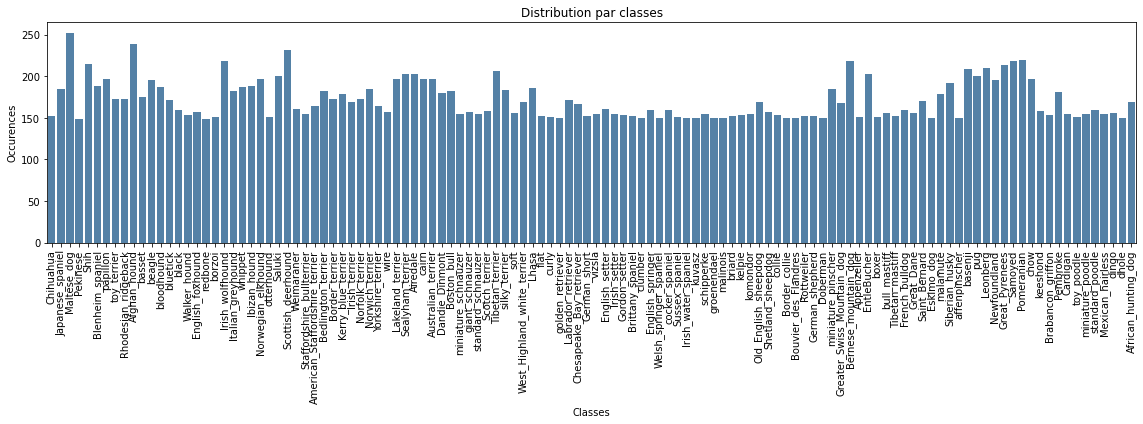

In [9]:
fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(classes.keys()), y=list(classes.values()), color='steelblue')
plt.title('Distribution par classes')
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.gcf().savefig('classes_freq', dpi=100)
plt.show()

## Distribution per size

In [10]:
image_size = {}
image_size['Very small'] = 0
image_size['Small'] = 0
image_size['Medium'] = 0
image_size['Large'] = 0
image_size['Very large'] = 0
image_width = []
image_height = []

for idx1, folder in enumerate(os.listdir(DATA_PATH)):
    if folder != 'train' and folder != 'val' and folder != 'test':
        FOLDERPATH = os.path.join(DATA_PATH, folder)

        for idx2, file in enumerate(os.listdir(FOLDERPATH)):
            FILEPATH = os.path.join(FOLDERPATH, file) 
            image = load_img(FILEPATH)
            
            image_width.append(image.width)
            image_height.append(image.height)
            
            if image.width <= 200:
                image_size['Very small'] += 1
            elif image.width <= 400:
                image_size['Small'] += 1
            elif image.width <= 600:
                image_size['Medium'] += 1
            elif image.width <= 800:
                image_size['Large'] += 1
            else:
                image_size['Very large'] += 1

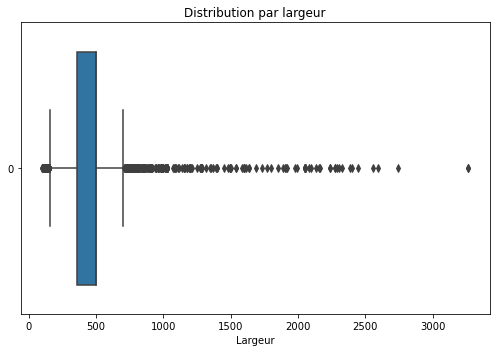

In [11]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=image_width, orient='horizontal')
plt.title('Distribution par largeur')
plt.xlabel('Largeur')
plt.tight_layout()
plt.gcf().savefig('image_width', dpi=100)
plt.show()

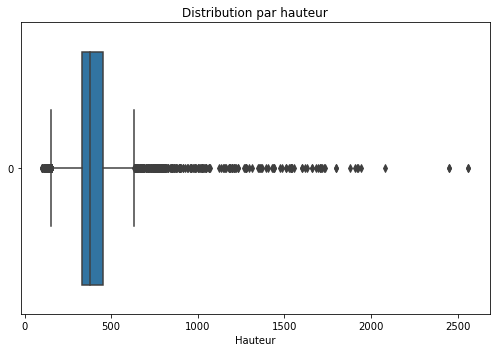

In [12]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=image_height, orient='horizontal')
plt.title('Distribution par hauteur')
plt.xlabel('Hauteur')
plt.tight_layout()
plt.gcf().savefig('image_height', dpi=100)
plt.show()

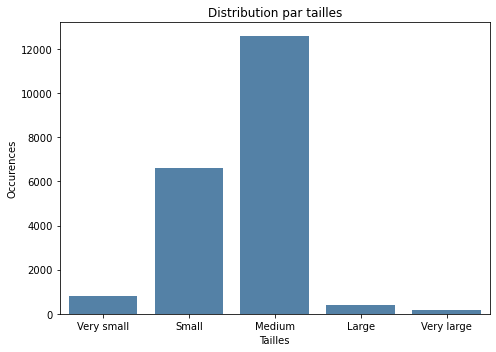

In [13]:
plt.figure(figsize=(7, 5))
sns.barplot(x=list(image_size.keys()), y=list(image_size.values()), color='steelblue')
plt.title('Distribution par tailles')
plt.xlabel('Tailles')
plt.ylabel('Occurences')
plt.tight_layout()
plt.gcf().savefig('size_freq', dpi=100)
plt.show()

# Preprocessing

## Equalization

### Test

In [14]:
image_path = 'C:/Users/james/source/python/P6/Images/n02085620-Chihuahua/n02085620_3593.jpg'

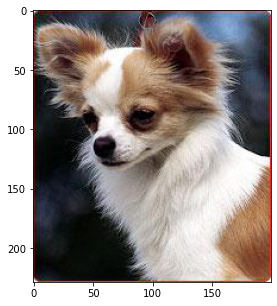

In [15]:
# Read image
img = cv.imread(image_path)
# Convert to RGB
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# Display image
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()

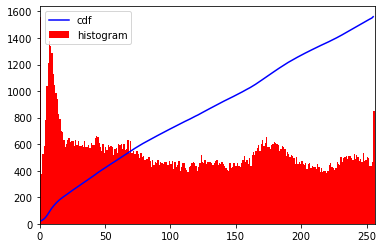

In [16]:
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [17]:
# Convert to gray
grayimg = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
# Equalization
equ = cv.equalizeHist(grayimg)

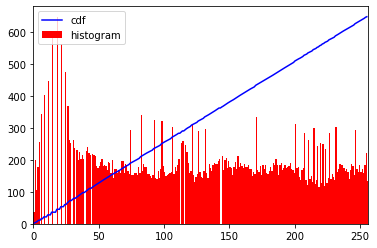

In [18]:
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

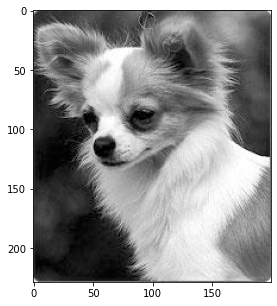

In [19]:
#Plots image
plt.figure(figsize=(5,5))
plt.imshow(equ, cmap='gray')
plt.show()

### Application

In [20]:
# Create new image folder
os.makedirs(NEWDATA_PATH, exist_ok=True)

# Create new classe folders
for idx1, folder in enumerate(os.listdir(DATA_PATH)):
    FOLDERPATH = os.path.join(NEWDATA_PATH, folder)
    os.makedirs(FOLDERPATH, exist_ok=True)

In [21]:
# Apply equalization then save the new images in the new folders
for idx1, folder in enumerate(os.listdir(DATA_PATH)):
    FOLDERPATH = os.path.join(DATA_PATH, folder)
    NEWFOLDERPATH = os.path.join(NEWDATA_PATH, folder)

    for idx2, file in enumerate(os.listdir(FOLDERPATH)):
        FILEPATH = os.path.join(FOLDERPATH, file) 

        # Read image
        image = cv.imread(FILEPATH)
        # Convert to RGB
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        # Convert to gray
        grayimage = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
        # Equalization
        equimage = cv.equalizeHist(grayimage)

        # Save new image
        NEWFILEPATH = os.path.join(NEWFOLDERPATH, file) 
        cv.imwrite(NEWFILEPATH, equimage)

## Data augmentation

### Visualization

In [22]:
img = tf.keras.preprocessing.image.load_img(image_path, target_size= (224,224))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

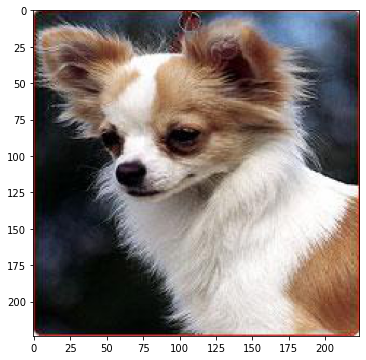

In [23]:
# Rescale for matplotlib visualization
img_tensor /= 255.

#Plots image
plt.figure(figsize=(6,6))
plt.imshow(img_tensor[0])
plt.show()

In [24]:
# Uses ImageDataGenerator to flip the images
datagen = ImageDataGenerator(rotation_range=120, 
                             brightness_range=[0.2, 1.5],
                             zoom_range=[0.3, 1.5], 
                             horizontal_flip=True)

In [25]:
# Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size=1)

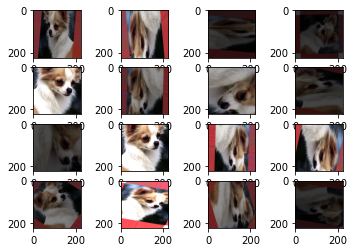

In [26]:
# Plots our figures
for i in range(1, 17):
    plt.subplot(4, 4, i)
    batch = pic.next()
    image_ = batch[0].astype('uint8')
    plt.imshow(image_)
plt.show()

### Preprocessing function

In [5]:
def preprocessing(from_preprocessing, function, augmented, batch_size, equalized):
    if from_preprocessing:
        # Dedicated to pre-trained models
        # DO NOT APPLY rescale
        if not augmented:
            ImageGenerator = ImageDataGenerator(preprocessing_function=function)
        else:
            ImageGenerator = ImageDataGenerator(rotation_range=120, 
                                                brightness_range=[0.2, 1.5],
                                                zoom_range=[0.3, 1.5], 
                                                horizontal_flip=True,
                                                preprocessing_function=function)
    else:
        # Dedicated to my own model
        if not augmented:
            ImageGenerator = ImageDataGenerator(rescale=1./255.)
        else:
            # With data augmentation
            ImageGenerator = ImageDataGenerator(rescale=1./255.,
                                                rotation_range=120, 
                                                brightness_range=[0.2, 1.5],
                                                zoom_range=[0.3, 1.5], 
                                                horizontal_flip=True
                                                )

    if not equalized:
        # Without equalization
        train = ImageGenerator.flow_from_directory('./Images/train/',
                                               target_size=(224, 224),
                                               batch_size=batch_size,
                                               class_mode='categorical')

        val = ImageGenerator.flow_from_directory('./Images/val/',
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

        test = ImageGenerator.flow_from_directory('./Images/test/',
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')
    
    else:
        # With equalization
        train = ImageGenerator.flow_from_directory('./NewImages/train/',
                                                   target_size=(224, 224),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')

        val = ImageGenerator.flow_from_directory('./NewImages/val/',
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

        test = ImageGenerator.flow_from_directory('./NewImages/test/',
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

    return train, val, test

# Data split (stratified)

In [28]:
train_size=0.80
val_size = 0.10

In [29]:
# Define train range per class
class_train = []

for item in class_details:
    class_train.append((item[0], round(item[1] * train_size)))

In [30]:
# Create train, validation and test dedicated folders
def createFolder(path, name):
    PATH = os.path.join(path, name)
    os.makedirs(PATH, exist_ok=True)

    for idx1, folder in enumerate(os.listdir(path)):
        if folder != 'train' and folder != 'val' and folder != 'test':
            FOLDERPATH = os.path.join(PATH, folder)
            os.makedirs(FOLDERPATH, exist_ok=True)

In [31]:
createFolder(DATA_PATH, 'train')
createFolder(NEWDATA_PATH, 'train')
createFolder(DATA_PATH, 'val')
createFolder(NEWDATA_PATH, 'val')
createFolder(DATA_PATH, 'test')
createFolder(NEWDATA_PATH, 'test')

In [32]:
# Split and copy images between train, validation and test sets

# For initial images
class_counter = 0

for idx1, folder in enumerate(os.listdir(DATA_PATH)):
    if folder != 'train' and folder != 'val' and folder != 'test':
        FOLDERPATH = os.path.join(DATA_PATH, folder)

        image_counter = 0
        for idx2, file in enumerate(os.listdir(FOLDERPATH)):
            image_counter += 1
            src = FOLDERPATH + '/' + file

            if image_counter <= class_train[class_counter][1]:
                if image_counter <= (class_train[class_counter][1] - (round(class_train[class_counter][1] * val_size))):
                    shutil.copyfile(src, './Images/train/' +
                                    folder + '/' + file)
                else:
                    shutil.copyfile(src, './Images/val/' + folder + '/' + file)
            else:
                shutil.copyfile(src, './Images/test/' + folder + '/' + file)
    class_counter += 1
    
# For equalized images
class_counter = 0

for idx1, folder in enumerate(os.listdir(NEWDATA_PATH)):
    if folder != 'train' and folder != 'val' and folder != 'test':
        FOLDERPATH = os.path.join(NEWDATA_PATH, folder)

        image_counter = 0
        for idx2, file in enumerate(os.listdir(FOLDERPATH)):
            image_counter += 1
            src = FOLDERPATH + '/' + file

            if image_counter <= class_train[class_counter][1]:
                if image_counter <= (class_train[class_counter][1] - (round(class_train[class_counter][1] * val_size))):
                    shutil.copyfile(src, './NewImages/train/' +
                                    folder + '/' + file)
                else:
                    shutil.copyfile(src, './NewImages/val/' + folder + '/' + file)
            else:
                shutil.copyfile(src, './NewImages/test/' + folder + '/' + file)
    class_counter += 1

# Approach 1 - My own CNN

## Building model

Inspired by InceptionV1

In [33]:
# function creating a inception convolution
def convolution(layer_in, n_filters, n_conv):
    # add convolutional layers
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

In [34]:
# function for creating a naive inception block
def inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5], axis=-1)
    return layer_out

In [35]:
def get_model():
    # define model input
    visible = Input(shape=(224, 224, 3))
    
    # add convolution
    layer = convolution(visible, 64, 1)
    # add convolution
    layer = convolution(layer, 64, 1)
    
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    
    # add max pooling
    layer = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer)
    
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    
    # add max pooling
    layer = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer)
    
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    
    # add average pooling
    layer = AveragePooling2D((2,2), strides=(2,2), padding='same')(layer)
    
    # add dropout (40%)
    layer = Dropout(0.4)(layer)
    
    # finalize model output
    layer = Flatten()(layer)
    layer = Dense(224, activation='relu')(layer)
    layer = Dense(120, activation='softmax')(layer)
    
    # create model
    model = Model(inputs=visible, outputs=layer)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    # summarize model
    model.summary()
    
    return model

## Fit

In [6]:
def get_early_stopping(patience):
    # Create early stopping callback
    return tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0,
                                            patience=patience, verbose=0,
                                            mode='auto', baseline=None,
                                            restore_best_weights=True
                                            )

In [7]:
def time_diff(start, end):
    difference = (end - start)
    total_seconds = difference.total_seconds()
    return total_seconds

In [8]:
def dump_session(session_num):
    joblib.dump(fit_time, 'session_' + str(session_num) + '_fit_time.jl')
    joblib.dump(pred_time, 'session_' + str(session_num) + '_pred_time.jl')
    joblib.dump(score, 'session_' + str(session_num) + '_score.jl')
    joblib.dump(loss, 'session_' + str(session_num) + '_loss.jl')

In [9]:
def load_session(session_num):
    # Reload data from previous session 
    fit_time = joblib.load('session_' + str(session_num) + '_fit_time.jl')
    pred_time = joblib.load('session_' + str(session_num) + '_pred_time.jl')
    loss = joblib.load('session_' + str(session_num) + '_loss.jl')
    score = joblib.load('session_' + str(session_num) + '_score.jl')
    
    return fit_time, pred_time, loss, score

In [39]:
fit_time = {}
pred_time = {}
score = {}
loss = {}

In [40]:
# Generate train, validation and test sets
# No data augmentation, no equalization
train_set, val_set, test_set = preprocessing(False, None, False, 32, False)

Found 14822 images belonging to 120 classes.
Found 1647 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.


In [41]:
# Create the model
cnn = get_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [42]:
# Fit the model
start = datetime.now()
history_cnn = cnn.fit(train_set,
                      epochs=100,
                      validation_data=val_set,
                      callbacks=[get_early_stopping(10)])
end = datetime.now()
print('Fit time:', time_diff(start, end) / len(train_set.filepaths))
fit_time['cnn'] = time_diff(start, end) / len(train_set.filepaths)

Epoch 1/100
464/464 [==============================] - 55s 105ms/step - loss: 4.7864 - accuracy: 0.0111 - val_loss: 4.7833 - val_accuracy: 0.0115
Epoch 2/100
464/464 [==============================] - 48s 103ms/step - loss: 4.7829 - accuracy: 0.0102 - val_loss: 4.7774 - val_accuracy: 0.0115
Epoch 3/100
464/464 [==============================] - 48s 104ms/step - loss: 4.7730 - accuracy: 0.0132 - val_loss: 4.7593 - val_accuracy: 0.0109
Epoch 4/100
464/464 [==============================] - 49s 105ms/step - loss: 4.7314 - accuracy: 0.0177 - val_loss: 4.6910 - val_accuracy: 0.0206
Epoch 5/100
464/464 [==============================] - 49s 105ms/step - loss: 4.6630 - accuracy: 0.0240 - val_loss: 4.6354 - val_accuracy: 0.0194
Epoch 6/100
464/464 [==============================] - 49s 106ms/step - loss: 4.6022 - accuracy: 0.0295 - val_loss: 4.5624 - val_accuracy: 0.0298
Epoch 7/100
464/464 [==============================] - 49s 105ms/step - loss: 4.5502 - accuracy: 0.0366 - val_loss: 4.5271 -

## Results

In [10]:
def display_results(model_name, hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylabel('Accuracy')
    #plt.ylim([min(plt.ylim()),1])
    plt.title(model_name + ' Training and Validation Accuracy')
    plt.legend(loc='upper left')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('epoch')
    plt.ylabel('Cross Entropy')
    #plt.ylim([0,1.0])
    plt.title(model_name + ' Training and Validation Loss')
    plt.legend(loc='upper left')
    plt.show()

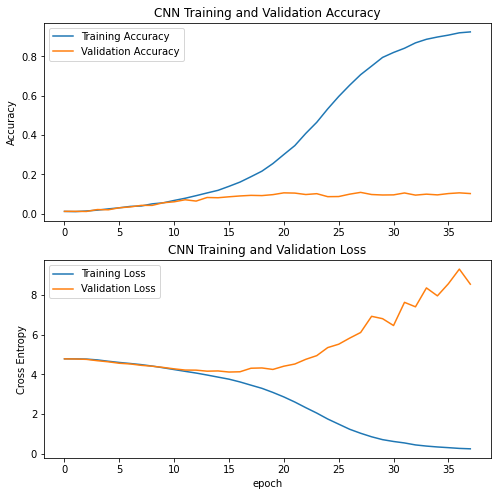

In [44]:
display_results('CNN', history_cnn)

In [45]:
results_cnn = cnn.evaluate(test_set)
print(f"test loss, test acc: {results_cnn}")
loss['cnn'] = results_cnn[0]
score['cnn'] = results_cnn[1]

129/129 [==============================] - 9s 67ms/step - loss: 6.0667 - accuracy: 0.1044
test loss, test acc: [6.066676139831543, 0.10435417294502258]


In [46]:
start = datetime.now()
predictions_cnn = cnn.predict(test_set)
end = datetime.now()
print('Prediction time:', time_diff(start, end) / len(test_set.filepaths))
pred_time['cnn'] = time_diff(start, end) / len(test_set.filepaths)

Prediction time: 0.0020956988567258574


## Check point

In [47]:
dump_session(1)

## Optimizations

- Overfitting: add dropout layers 
- Normalization: add BatchNormalization layers
- Optimizer: switch from sgd to adam

In [48]:
def get_model_tuned():
    # define model input
    visible = Input(shape=(224, 224, 3))
    
    # add convolution
    layer = convolution(visible, 64, 1)
    # add convolution
    layer = convolution(layer, 64, 1)
    
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    
    # add max pooling
    layer = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer)
    
    # add normalisation
    layer = BatchNormalization()(layer)
    
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    
    # add max pooling
    layer = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer)
    
    # add normalisation
    layer = BatchNormalization()(layer)
    
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    # add inception module
    layer = inception_module(layer, 64, 128, 32)
    
    # add average pooling
    layer = AveragePooling2D((2,2), strides=(2,2), padding='same')(layer)
    
    # add dropout (40%)
    layer = Dropout(0.4)(layer)
    
    # finalize model output
    layer = Flatten()(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(224, activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(120, activation='softmax')(layer)
    
    # create model
    model = Model(inputs=visible, outputs=layer)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize model
    model.summary()
    
    return model

- data augmentation + equalization

In [49]:
# Generate train, validation and test sets
# Data augmentation and equalization
train_aug_equ, val_aug_equ, test_aug_equ = preprocessing(False, None, True, 32, True)

Found 14822 images belonging to 120 classes.
Found 1647 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.


- data augmentation but no equalization

In [50]:
# Generate train, validation and test sets
# Data augmentation and no equalization
train_aug_noequ, val_aug_noequ, test_aug_noequ = preprocessing(False, None, True, 32, False)

Found 14822 images belonging to 120 classes.
Found 1647 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.


## Fit

In [51]:
# Create the model
cnn_tuned = get_model_tuned()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 112, 112, 64) 36928       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

In [52]:
# Fit the model with data augmentation and equalization
start = datetime.now()
history_cnn_tuned_aug_equ = cnn_tuned.fit(train_aug_equ,
                                          epochs=100,
                                          validation_data=val_aug_equ,
                                          callbacks=[get_early_stopping(10)])
end = datetime.now()
print('Fit time:', time_diff(start, end) / len(train_set.filepaths))
fit_time['cnn_tuned_aug_equ'] = time_diff(
    start, end) / len(train_set.filepaths)

Epoch 1/100
464/464 [==============================] - 134s 286ms/step - loss: 5.2343 - accuracy: 0.0103 - val_loss: 4.9891 - val_accuracy: 0.0091
Epoch 2/100
464/464 [==============================] - 138s 297ms/step - loss: 5.0293 - accuracy: 0.0112 - val_loss: 4.7822 - val_accuracy: 0.0091
Epoch 3/100
464/464 [==============================] - 144s 309ms/step - loss: 4.9375 - accuracy: 0.0132 - val_loss: 4.8552 - val_accuracy: 0.0152
Epoch 4/100
464/464 [==============================] - 142s 305ms/step - loss: 4.8455 - accuracy: 0.0136 - val_loss: 5.4274 - val_accuracy: 0.0140
Epoch 5/100
464/464 [==============================] - 138s 298ms/step - loss: 4.7991 - accuracy: 0.0155 - val_loss: 4.9125 - val_accuracy: 0.0140
Epoch 6/100
464/464 [==============================] - 139s 300ms/step - loss: 4.7499 - accuracy: 0.0174 - val_loss: 6.2235 - val_accuracy: 0.0073
Epoch 7/100
464/464 [==============================] - 135s 291ms/step - loss: 4.7159 - accuracy: 0.0184 - val_loss: 4

In [53]:
# Fit the model with data augmentation but no equalization
start = datetime.now()
history_cnn_tuned_aug_noequ = cnn_tuned.fit(train_aug_noequ,
                                            epochs=100,
                                            validation_data=val_aug_noequ,
                                            callbacks=[get_early_stopping(10)])
end = datetime.now()
print('Fit time:', time_diff(start, end) / len(train_set.filepaths))
fit_time['cnn_tuned_aug_noequ'] = time_diff(
    start, end) / len(train_set.filepaths)

Epoch 1/100
464/464 [==============================] - 141s 304ms/step - loss: 4.0664 - accuracy: 0.0808 - val_loss: 3.9502 - val_accuracy: 0.1032
Epoch 2/100
464/464 [==============================] - 141s 303ms/step - loss: 4.0135 - accuracy: 0.0882 - val_loss: 4.1367 - val_accuracy: 0.0850
Epoch 3/100
464/464 [==============================] - 140s 301ms/step - loss: 3.9644 - accuracy: 0.0939 - val_loss: 3.9289 - val_accuracy: 0.1081
Epoch 4/100
464/464 [==============================] - 140s 302ms/step - loss: 3.9399 - accuracy: 0.0924 - val_loss: 4.0014 - val_accuracy: 0.0838
Epoch 5/100
464/464 [==============================] - 141s 303ms/step - loss: 3.9068 - accuracy: 0.0986 - val_loss: 3.8401 - val_accuracy: 0.1129
Epoch 6/100
464/464 [==============================] - 140s 302ms/step - loss: 3.8797 - accuracy: 0.1023 - val_loss: 3.9922 - val_accuracy: 0.1111
Epoch 7/100
464/464 [==============================] - 141s 303ms/step - loss: 3.8737 - accuracy: 0.1001 - val_loss: 3

## Results

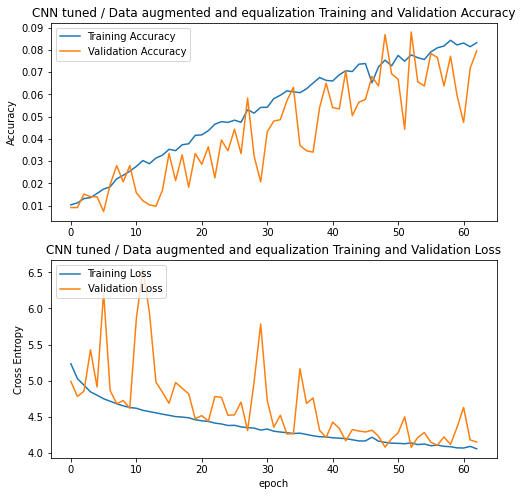

In [54]:
display_results('CNN tuned / Data augmented and equalization', history_cnn_tuned_aug_equ)

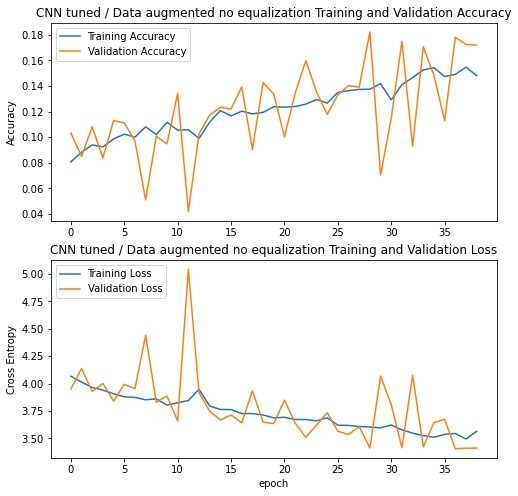

In [55]:
display_results('CNN tuned / Data augmented no equalization', history_cnn_tuned_aug_noequ)

In [56]:
results_cnn_tuned_aug_equ = cnn_tuned.evaluate(test_aug_equ)
print(f"test loss, test acc: {results_cnn_tuned_aug_equ}")
loss['cnn_tuned_aug_equ'] = results_cnn_tuned_aug_equ[0]
score['cnn_tuned_aug_equ'] = results_cnn_tuned_aug_equ[1]

129/129 [==============================] - 33s 256ms/step - loss: 4.6119 - accuracy: 0.0637
test loss, test acc: [4.611939430236816, 0.06373145431280136]


In [57]:
results_cnn_tuned_aug_noequ = cnn_tuned.evaluate(test_aug_noequ)
print(f"test loss, test acc: {results_cnn_tuned_aug_noequ}")
loss['cnn_tuned_aug_noequ'] = results_cnn_tuned_aug_noequ[0]
score['cnn_tuned_aug_noequ'] = results_cnn_tuned_aug_noequ[1]

129/129 [==============================] - 35s 271ms/step - loss: 3.4753 - accuracy: 0.1620
test loss, test acc: [3.475297451019287, 0.16200438141822815]


In [58]:
start = datetime.now()
predictions_cnn_tuned_aug_equ = cnn_tuned.predict(test_aug_equ)
end = datetime.now()
print('Prediction time:', time_diff(start, end) / len(test_set.filepaths))
pred_time['cnn_tuned_aug_equ'] = time_diff(start, end) / len(test_set.filepaths)

Prediction time: 0.008138524689856484


In [59]:
start = datetime.now()
predictions_cnn_tuned_aug_noequ = cnn_tuned.predict(test_aug_noequ)
end = datetime.now()
print('Prediction time:', time_diff(start, end) / len(test_set.filepaths))
pred_time['cnn_tuned_aug_noequ'] = time_diff(start, end) / len(test_set.filepaths)

Prediction time: 0.008511756263682802


## Check point

In [60]:
dump_session(2)

## Comparative results

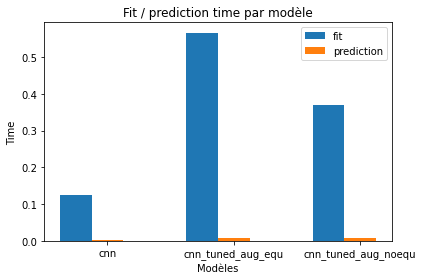

In [68]:
ind = np.arange(3) 
width = 0.25      
plt.bar(ind, fit_time.values(), width, label='fit')
plt.bar(ind + width, pred_time.values(), width, label='prediction')

plt.xlabel('Modèles')
plt.ylabel('Time')
plt.title('Fit / prediction time par modèle')

plt.xticks(ind + width, ['cnn', 'cnn_tuned_aug_equ', 'cnn_tuned_aug_noequ'])
plt.legend(loc='best')

plt.tight_layout()
plt.gcf().savefig('fit_approche1', dpi=100)
plt.show()

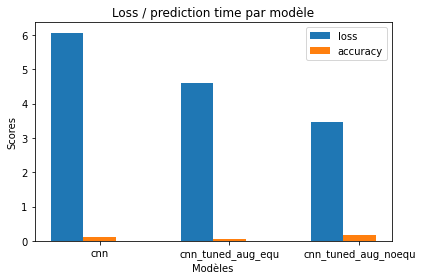

In [62]:
ind = np.arange(3) 
width = 0.25       
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='accuracy')

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Loss / prediction time par modèle')

plt.xticks(ind + width, ['cnn', 'cnn_tuned_aug_equ', 'cnn_tuned_aug_noequ'])
plt.legend(loc='best')

plt.tight_layout()
plt.gcf().savefig('loss_approche1', dpi=100)
plt.show()

# Approach 2 - Using pre-trained models

In [11]:
# Reload data from session 2
fit_time, pred_time, loss, score = load_session(2)

In [12]:
# Clean past unnecessary data
del fit_time['cnn']
del fit_time['cnn_tuned_aug_equ']
del fit_time['cnn_tuned_aug_noequ']
del pred_time['cnn']
del pred_time['cnn_tuned_aug_equ']
del pred_time['cnn_tuned_aug_noequ']
del loss['cnn']
del loss['cnn_tuned_aug_equ']
del loss['cnn_tuned_aug_noequ']
del score['cnn']
del score['cnn_tuned_aug_equ']
del score['cnn_tuned_aug_noequ']

In [13]:
def get_pretrained_model(name):
    # load model
    if name == 'InceptionV3':
        model = InceptionV3(include_top=False, input_shape=(224, 224, 3), pooling=None)
    elif name == 'ResNet50':
        model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling=None)
    elif name == 'VGG16':
        model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling=None)

    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False

    # add new classifier layers
    flatten = Flatten()(model.layers[-1].output)
    dense1024 = Dense(1024, activation='relu')(flatten)
    batch1 = BatchNormalization()(dense1024)
    dropout1 = Dropout(0.5)(batch1)
    dense512 = Dense(512, activation='relu')(dropout1)
    batch2 = BatchNormalization()(dense512)
    dropout2 = Dropout(0.5)(batch2)
    output = Dense(120, activation='softmax')(dropout2)

    # create model
    model = Model(inputs=model.inputs, outputs=output)

    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

    return model

## InceptionV3

In [14]:
# Generate train, validation and test sets
# No data augmentation and no equalization
train, val, test = preprocessing(True, pii, False, 32, False)

Found 14822 images belonging to 120 classes.
Found 1647 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.


In [15]:
# load model
model = get_pretrained_model('InceptionV3')

In [16]:
# Fit the model
start = datetime.now()
history_InceptionV3 = model.fit(train,
                                epochs=100,
                                validation_data=val,
                                callbacks=[get_early_stopping(10)])
end = datetime.now()
print('Fit time:', time_diff(start, end) / len(train.filepaths))
fit_time['InceptionV3'] = time_diff(start, end) / len(train.filepaths)

Epoch 1/100
464/464 [==============================] - 44s 80ms/step - loss: 1.5590 - accuracy: 0.6134 - val_loss: 0.8713 - val_accuracy: 0.7650
Epoch 2/100
464/464 [==============================] - 35s 75ms/step - loss: 0.8665 - accuracy: 0.7590 - val_loss: 0.7734 - val_accuracy: 0.7832
Epoch 3/100
464/464 [==============================] - 35s 75ms/step - loss: 0.6914 - accuracy: 0.7944 - val_loss: 0.7325 - val_accuracy: 0.7948
Epoch 4/100
464/464 [==============================] - 35s 75ms/step - loss: 0.5658 - accuracy: 0.8245 - val_loss: 0.7839 - val_accuracy: 0.7978
Epoch 5/100
464/464 [==============================] - 35s 76ms/step - loss: 0.4947 - accuracy: 0.8456 - val_loss: 0.7778 - val_accuracy: 0.7905
Epoch 6/100
464/464 [==============================] - 35s 75ms/step - loss: 0.4101 - accuracy: 0.8710 - val_loss: 0.8010 - val_accuracy: 0.7887
Epoch 7/100
464/464 [==============================] - 35s 76ms/step - loss: 0.3547 - accuracy: 0.8829 - val_loss: 0.8583 - val_ac

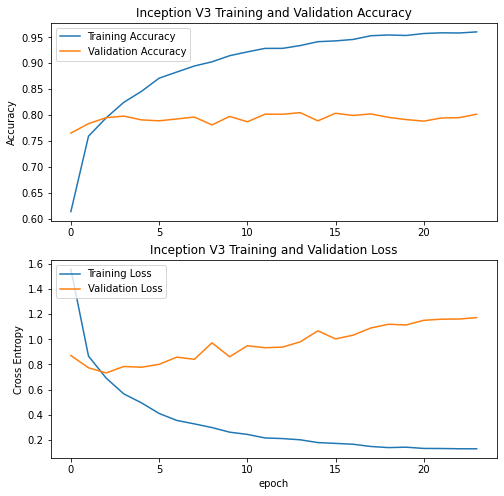

In [17]:
display_results('Inception V3', history_InceptionV3)

In [18]:
results_InceptionV3 = model.evaluate(test)
print(f"test loss, test acc: {results_InceptionV3}")
loss['InceptionV3'] = results_InceptionV3[0]
score['InceptionV3'] = results_InceptionV3[1]

129/129 [==============================] - 9s 69ms/step - loss: 0.9911 - accuracy: 0.7923
test loss, test acc: [0.9911415576934814, 0.7922646403312683]


In [19]:
start = datetime.now()
predictions_InceptionV3 = model.predict(test)
end = datetime.now()
print('Prediction time:', time_diff(start, end) / len(test.filepaths))
pred_time['InceptionV3'] = time_diff(start, end) / len(test.filepaths)

Prediction time: 0.0022885069326198004


### Check point

In [20]:
dump_session(3)

In [21]:
model.save('InceptionV3')

INFO:tensorflow:Assets written to: InceptionV3\assets


## ResNet50

In [22]:
# Generate train, validation and test sets
# No data augmentation and no equalization
train, val, test = preprocessing(True, pir, False, 32, False)

Found 14822 images belonging to 120 classes.
Found 1647 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.


In [23]:
# load model
model = get_pretrained_model('ResNet50')

In [24]:
# Fit the model
start = datetime.now()
history_ResNet50 = model.fit(train,
                             epochs=100,
                             validation_data=val,
                             callbacks=[get_early_stopping(10)])
end = datetime.now()
print('Fit time:', time_diff(start, end) / len(train.filepaths))
fit_time['ResNet50'] = time_diff(start, end) / len(train.filepaths)

Epoch 1/100
464/464 [==============================] - 43s 86ms/step - loss: 2.3526 - accuracy: 0.4195 - val_loss: 1.0061 - val_accuracy: 0.6903
Epoch 2/100
464/464 [==============================] - 38s 82ms/step - loss: 0.9631 - accuracy: 0.7085 - val_loss: 0.9124 - val_accuracy: 0.7201
Epoch 3/100
464/464 [==============================] - 68s 147ms/step - loss: 0.5820 - accuracy: 0.8178 - val_loss: 0.9046 - val_accuracy: 0.7225
Epoch 4/100
464/464 [==============================] - 39s 84ms/step - loss: 0.3659 - accuracy: 0.8858 - val_loss: 0.9284 - val_accuracy: 0.7341
Epoch 5/100
464/464 [==============================] - 39s 84ms/step - loss: 0.2719 - accuracy: 0.9176 - val_loss: 1.0124 - val_accuracy: 0.7231
Epoch 6/100
464/464 [==============================] - 39s 84ms/step - loss: 0.2384 - accuracy: 0.9250 - val_loss: 1.0464 - val_accuracy: 0.7432
Epoch 7/100
464/464 [==============================] - 39s 83ms/step - loss: 0.2031 - accuracy: 0.9342 - val_loss: 1.0848 - val_a

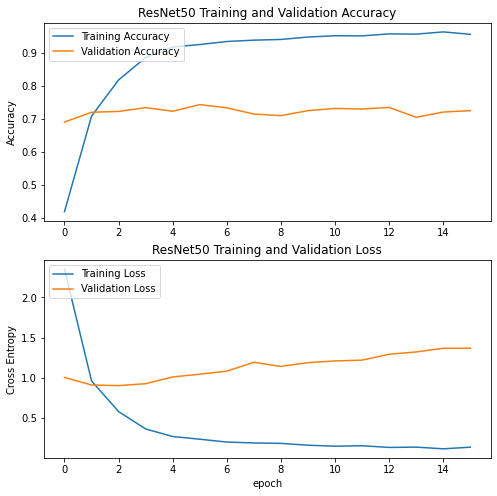

In [25]:
display_results('ResNet50', history_ResNet50)

In [26]:
results_ResNet50 = model.evaluate(test)
print(f"test loss, test acc: {results_ResNet50}")
loss['ResNet50'] = results_ResNet50[0]
score['ResNet50'] = results_ResNet50[1]

129/129 [==============================] - 10s 75ms/step - loss: 1.0870 - accuracy: 0.7181
test loss, test acc: [1.0870212316513062, 0.7180734872817993]


In [27]:
start = datetime.now()
predictions_ResNet50 = model.predict(test)
end = datetime.now()
print('Prediction time:', time_diff(start, end) / len(test.filepaths))
pred_time['ResNet50'] = time_diff(start, end) / len(test.filepaths)

Prediction time: 0.0024875475553393332


### Check point

In [28]:
dump_session(4)

In [29]:
# Model not saved because accuracy is less than InceptionV3
#model.save('ResNet50')

## VGG16

In [30]:
# Reload data from session 4
fit_time, pred_time, loss, score = load_session(4)

In [31]:
# Generate train, validation and test sets
# No data augmentation and no equalization
train, val, test = preprocessing(True, piv, False, 32, False)

Found 14822 images belonging to 120 classes.
Found 1647 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.


In [32]:
# load model
model = get_pretrained_model('VGG16')

In [33]:
# Fit the model
start = datetime.now()
history_VGG16 = model.fit(train,
                          epochs=100,
                          validation_data=val,
                          callbacks=[get_early_stopping(10)])
end = datetime.now()
print('Fit time:', time_diff(start, end) / len(train.filepaths))
fit_time['VGG16'] = time_diff(start, end) / len(train.filepaths)

Epoch 1/100
464/464 [==============================] - 45s 91ms/step - loss: 2.8486 - accuracy: 0.3112 - val_loss: 1.3378 - val_accuracy: 0.6102
Epoch 2/100
464/464 [==============================] - 41s 88ms/step - loss: 1.3592 - accuracy: 0.6048 - val_loss: 1.0954 - val_accuracy: 0.6667
Epoch 3/100
464/464 [==============================] - 39s 84ms/step - loss: 0.9150 - accuracy: 0.7189 - val_loss: 1.0954 - val_accuracy: 0.6849
Epoch 4/100
464/464 [==============================] - 38s 82ms/step - loss: 0.6621 - accuracy: 0.7907 - val_loss: 1.1736 - val_accuracy: 0.6709
Epoch 5/100
464/464 [==============================] - 39s 83ms/step - loss: 0.5047 - accuracy: 0.8394 - val_loss: 1.1770 - val_accuracy: 0.6673
Epoch 6/100
464/464 [==============================] - 40s 85ms/step - loss: 0.4054 - accuracy: 0.8706 - val_loss: 1.2709 - val_accuracy: 0.6667
Epoch 7/100
464/464 [==============================] - 39s 85ms/step - loss: 0.3748 - accuracy: 0.8804 - val_loss: 1.3208 - val_ac

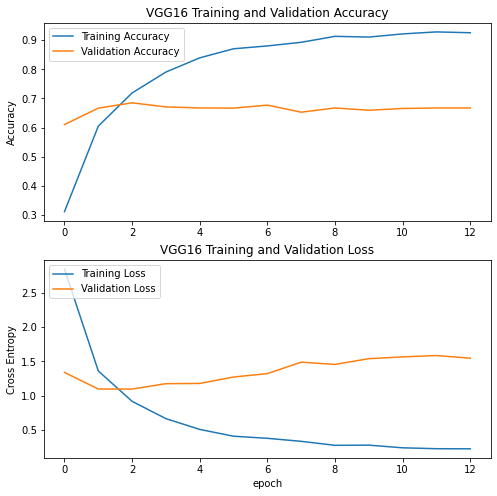

In [34]:
display_results('VGG16', history_VGG16)

In [35]:
results_VGG16 = model.evaluate(test)
print(f"test loss, test acc: {results_VGG16}")
loss['VGG16'] = results_VGG16[0]
score['VGG16'] = results_VGG16[1]

129/129 [==============================] - 10s 75ms/step - loss: 1.1840 - accuracy: 0.6495
test loss, test acc: [1.183984398841858, 0.6494770050048828]


In [36]:
start = datetime.now()
predictions_VGG16 = model.predict(test)
end = datetime.now()
print('Prediction time:', time_diff(start, end) / len(test.filepaths))
pred_time['VGG16'] = time_diff(start, end) / len(test.filepaths)

Prediction time: 0.0023347521284359037


### Check point

In [37]:
dump_session(5)

In [38]:
# Model not saved because accuracy is less than InceptionV3
#model.save('VGG16')

## Comparative results

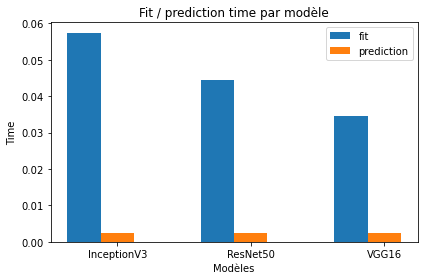

In [39]:
ind = np.arange(3) 
width = 0.25       
plt.bar(ind, fit_time.values(), width, label='fit')
plt.bar(ind + width, pred_time.values(), width, label='prediction')

plt.xlabel('Modèles')
plt.ylabel('Time')
plt.title('Fit / prediction time par modèle')

plt.xticks(ind + width, ['InceptionV3', 'ResNet50', 'VGG16'])
plt.legend(loc='best')

plt.tight_layout()
plt.gcf().savefig('fit_approche2', dpi=100)
plt.show()

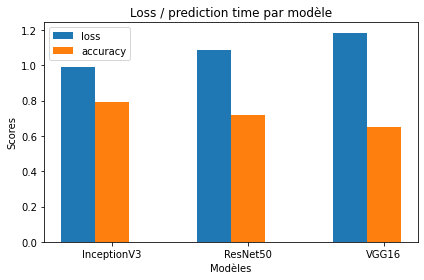

In [40]:
ind = np.arange(3) 
width = 0.25       
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='accuracy')

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Loss / prediction time par modèle')

plt.xticks(ind + width, ['InceptionV3', 'ResNet50', 'VGG16'])
plt.legend(loc='best')

plt.tight_layout()
plt.gcf().savefig('loss_approche2', dpi=100)
plt.show()

## InceptionV3 fine tuning

In [11]:
# Reload data from session 5
fit_time, pred_time, loss, score = load_session(5)

In [12]:
# Generate train, validation and test sets
# No data augmentation and no equalization
train, val, test = preprocessing(True, pii, False, 32, False)

Found 14822 images belonging to 120 classes.
Found 1647 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.


In [13]:
# Load model
base_model = tf.keras.models.load_model('InceptionV3')

In [14]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Test stratégy 1 - Unfreeze all layers

In [15]:
# Unfreeze model layers
base_model.trainable = True

----------------------------------------------------------------------------------------------------
Learning rate: 0.0001
Epoch 1/20
464/464 [==============================] - 81s 152ms/step - loss: 1.4676 - accuracy: 0.6705 - val_loss: 1.5479 - val_accuracy: 0.6806
Epoch 2/20
464/464 [==============================] - 68s 145ms/step - loss: 0.7872 - accuracy: 0.7955 - val_loss: 1.2904 - val_accuracy: 0.7237
Epoch 3/20
464/464 [==============================] - 68s 146ms/step - loss: 0.4844 - accuracy: 0.8626 - val_loss: 1.3276 - val_accuracy: 0.7219
Epoch 4/20
464/464 [==============================] - 68s 146ms/step - loss: 0.3685 - accuracy: 0.8917 - val_loss: 1.4077 - val_accuracy: 0.7098
Epoch 5/20
464/464 [==============================] - 68s 146ms/step - loss: 0.3275 - accuracy: 0.9017 - val_loss: 1.3523 - val_accuracy: 0.7055
Epoch 6/20
464/464 [==============================] - 68s 147ms/step - loss: 0.2565 - accuracy: 0.9237 - val_loss: 1.6250 - val_accuracy: 0.6970


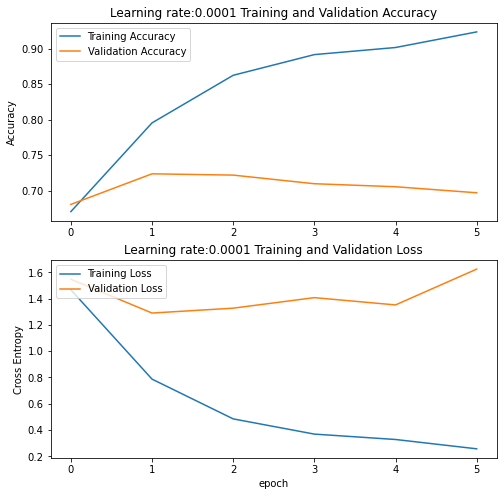


----------------------------------------------------------------------------------------------------
Learning rate: 1e-05
Epoch 1/20
464/464 [==============================] - 75s 147ms/step - loss: 0.3451 - accuracy: 0.8960 - val_loss: 1.0660 - val_accuracy: 0.7620
Epoch 2/20
464/464 [==============================] - 68s 146ms/step - loss: 0.2268 - accuracy: 0.9314 - val_loss: 1.0351 - val_accuracy: 0.7668
Epoch 3/20
464/464 [==============================] - 68s 145ms/step - loss: 0.1632 - accuracy: 0.9471 - val_loss: 1.0375 - val_accuracy: 0.7693
Epoch 4/20
464/464 [==============================] - 68s 146ms/step - loss: 0.1214 - accuracy: 0.9613 - val_loss: 1.0345 - val_accuracy: 0.7644
Epoch 5/20
464/464 [==============================] - 67s 145ms/step - loss: 0.1024 - accuracy: 0.9680 - val_loss: 1.0508 - val_accuracy: 0.7656
Epoch 6/20
464/464 [==============================] - 68s 145ms/step - loss: 0.0902 - accuracy: 0.9713 - val_loss: 1.0323 - val_accuracy: 0.7729
Epoch 7

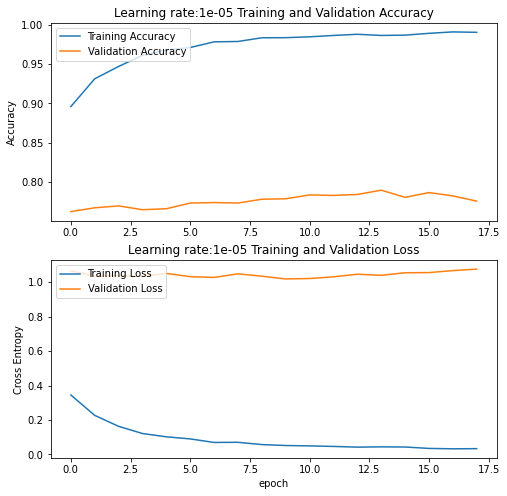


----------------------------------------------------------------------------------------------------
Learning rate: 1e-06
Epoch 1/20
464/464 [==============================] - 73s 147ms/step - loss: 0.0372 - accuracy: 0.9890 - val_loss: 1.0347 - val_accuracy: 0.7869
Epoch 2/20
464/464 [==============================] - 67s 145ms/step - loss: 0.0348 - accuracy: 0.9902 - val_loss: 1.0333 - val_accuracy: 0.7845
Epoch 3/20
464/464 [==============================] - 67s 145ms/step - loss: 0.0311 - accuracy: 0.9912 - val_loss: 1.0302 - val_accuracy: 0.7857
Epoch 4/20
464/464 [==============================] - 67s 145ms/step - loss: 0.0314 - accuracy: 0.9906 - val_loss: 1.0268 - val_accuracy: 0.7875
Epoch 5/20
464/464 [==============================] - 67s 145ms/step - loss: 0.0287 - accuracy: 0.9923 - val_loss: 1.0221 - val_accuracy: 0.7851
Epoch 6/20
464/464 [==============================] - 67s 145ms/step - loss: 0.0283 - accuracy: 0.9927 - val_loss: 1.0220 - val_accuracy: 0.7875
Epoch 7

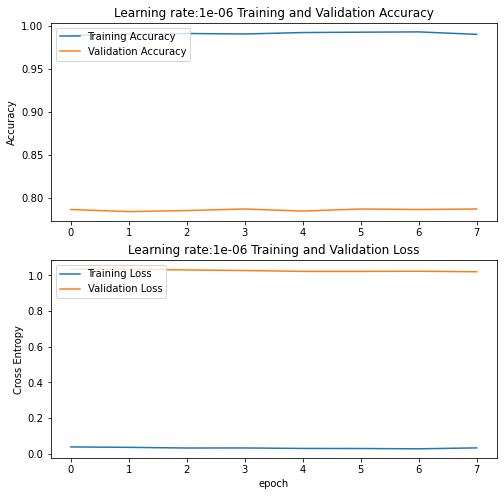

In [16]:
# Test learning rates
for lr in [1e-4, 1e-5, 1e-6]:
    print('-'*100)
    print('Learning rate:', lr)
    # define new model
    model = Model(inputs=base_model.inputs, outputs=base_model.output)
    # Build Adam optimizer with selected learning rate
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])
    # Fit the model
    history = model.fit(train,
                        epochs=20,
                        validation_data=val,
                        callbacks=[get_early_stopping(4)])
    # Display history
    display_results('Learning rate:' + str(lr), history) 
    
    model = None
    print('')

### Test stratégy 2 - Unfreeze only a few layers

In [17]:
# Display layers
for idx, layer in enumerate(base_model.layers):
    if idx > 250:
        print(idx, layer.name)

251 activation_80
252 conv2d_77
253 conv2d_81
254 batch_normalization_77
255 batch_normalization_81
256 activation_77
257 activation_81
258 conv2d_78
259 conv2d_79
260 conv2d_82
261 conv2d_83
262 average_pooling2d_7
263 conv2d_76
264 batch_normalization_78
265 batch_normalization_79
266 batch_normalization_82
267 batch_normalization_83
268 conv2d_84
269 batch_normalization_76
270 activation_78
271 activation_79
272 activation_82
273 activation_83
274 batch_normalization_84
275 activation_76
276 mixed9_0
277 concatenate
278 activation_84
279 mixed9
280 conv2d_89
281 batch_normalization_89
282 activation_89
283 conv2d_86
284 conv2d_90
285 batch_normalization_86
286 batch_normalization_90
287 activation_86
288 activation_90
289 conv2d_87
290 conv2d_88
291 conv2d_91
292 conv2d_92
293 average_pooling2d_8
294 conv2d_85
295 batch_normalization_87
296 batch_normalization_88
297 batch_normalization_91
298 batch_normalization_92
299 conv2d_93
300 batch_normalization_85
301 activation_87
302 acti

----------------------------------------------------------------------------------------------------
fine_tune_at: 283
Learning rate: 0.0001
Epoch 1/20
464/464 [==============================] - 43s 82ms/step - loss: 0.0357 - accuracy: 0.9923 - val_loss: 1.1867 - val_accuracy: 0.7723
Epoch 2/20
464/464 [==============================] - 37s 79ms/step - loss: 0.0317 - accuracy: 0.9924 - val_loss: 1.1426 - val_accuracy: 0.7723
Epoch 3/20
464/464 [==============================] - 37s 79ms/step - loss: 0.0270 - accuracy: 0.9940 - val_loss: 1.1047 - val_accuracy: 0.7772
Epoch 4/20
464/464 [==============================] - 38s 81ms/step - loss: 0.0246 - accuracy: 0.9937 - val_loss: 1.1298 - val_accuracy: 0.7723
Epoch 5/20
464/464 [==============================] - 38s 82ms/step - loss: 0.0218 - accuracy: 0.9945 - val_loss: 1.1856 - val_accuracy: 0.7699
Epoch 6/20
464/464 [==============================] - 38s 82ms/step - loss: 0.0220 - accuracy: 0.9948 - val_loss: 1.1728 - val_accuracy: 0.

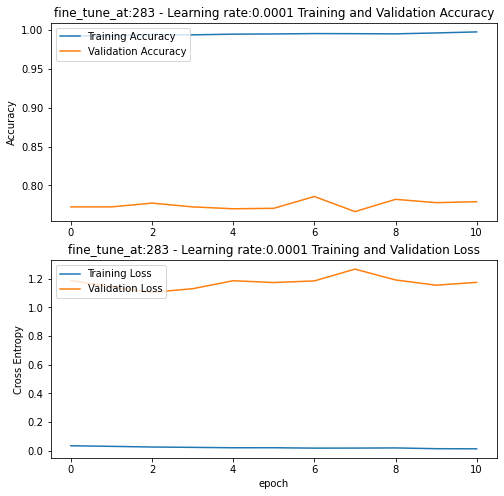


Learning rate: 1e-05
Epoch 1/20
464/464 [==============================] - 40s 80ms/step - loss: 0.0127 - accuracy: 0.9970 - val_loss: 1.1566 - val_accuracy: 0.7851
Epoch 2/20
464/464 [==============================] - 36s 78ms/step - loss: 0.0103 - accuracy: 0.9975 - val_loss: 1.1460 - val_accuracy: 0.7845
Epoch 3/20
464/464 [==============================] - 36s 78ms/step - loss: 0.0104 - accuracy: 0.9982 - val_loss: 1.1401 - val_accuracy: 0.7826
Epoch 4/20
464/464 [==============================] - 36s 78ms/step - loss: 0.0082 - accuracy: 0.9982 - val_loss: 1.1420 - val_accuracy: 0.7832
Epoch 5/20
464/464 [==============================] - 36s 78ms/step - loss: 0.0088 - accuracy: 0.9979 - val_loss: 1.1377 - val_accuracy: 0.7869
Epoch 6/20
464/464 [==============================] - 38s 81ms/step - loss: 0.0071 - accuracy: 0.9978 - val_loss: 1.1382 - val_accuracy: 0.7857
Epoch 7/20
464/464 [==============================] - 38s 81ms/step - loss: 0.0082 - accuracy: 0.9978 - val_loss: 

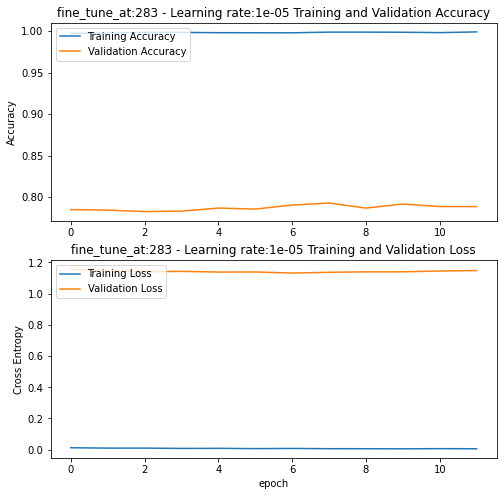


----------------------------------------------------------------------------------------------------
fine_tune_at: 289
Learning rate: 0.0001
Epoch 1/20
464/464 [==============================] - 43s 82ms/step - loss: 0.0139 - accuracy: 0.9975 - val_loss: 1.1732 - val_accuracy: 0.7778
Epoch 2/20
464/464 [==============================] - 37s 80ms/step - loss: 0.0122 - accuracy: 0.9976 - val_loss: 1.1671 - val_accuracy: 0.7826
Epoch 3/20
464/464 [==============================] - 37s 79ms/step - loss: 0.0080 - accuracy: 0.9984 - val_loss: 1.1705 - val_accuracy: 0.7790
Epoch 4/20
464/464 [==============================] - 37s 80ms/step - loss: 0.0115 - accuracy: 0.9980 - val_loss: 1.1736 - val_accuracy: 0.7832
Epoch 5/20
464/464 [==============================] - 37s 79ms/step - loss: 0.0102 - accuracy: 0.9982 - val_loss: 1.1874 - val_accuracy: 0.7832
Epoch 6/20
464/464 [==============================] - 37s 80ms/step - loss: 0.0101 - accuracy: 0.9982 - val_loss: 1.1943 - val_accuracy: 0

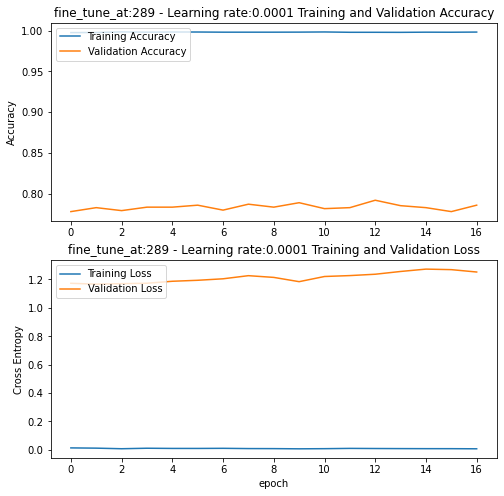


Learning rate: 1e-05
Epoch 1/20
464/464 [==============================] - 40s 80ms/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 1.2285 - val_accuracy: 0.7899
Epoch 2/20
464/464 [==============================] - 37s 79ms/step - loss: 0.0057 - accuracy: 0.9986 - val_loss: 1.2233 - val_accuracy: 0.7899
Epoch 3/20
464/464 [==============================] - 37s 79ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 1.2199 - val_accuracy: 0.7911
Epoch 4/20
464/464 [==============================] - 36s 79ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 1.2169 - val_accuracy: 0.7899
Epoch 5/20
464/464 [==============================] - 37s 79ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 1.2183 - val_accuracy: 0.7905
Epoch 6/20
464/464 [==============================] - 37s 79ms/step - loss: 0.0052 - accuracy: 0.9989 - val_loss: 1.2142 - val_accuracy: 0.7930
Epoch 7/20
464/464 [==============================] - 37s 80ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 

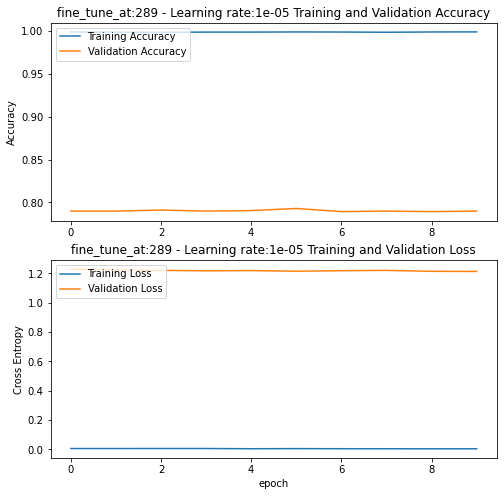


----------------------------------------------------------------------------------------------------
fine_tune_at: 294
Learning rate: 0.0001
Epoch 1/20
464/464 [==============================] - 44s 83ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 1.2440 - val_accuracy: 0.7887
Epoch 2/20
464/464 [==============================] - 38s 81ms/step - loss: 0.0073 - accuracy: 0.9985 - val_loss: 1.2361 - val_accuracy: 0.7930
Epoch 3/20
464/464 [==============================] - 38s 81ms/step - loss: 0.0077 - accuracy: 0.9982 - val_loss: 1.2303 - val_accuracy: 0.7869
Epoch 4/20
464/464 [==============================] - 38s 81ms/step - loss: 0.0073 - accuracy: 0.9985 - val_loss: 1.2275 - val_accuracy: 0.7893
Epoch 5/20
464/464 [==============================] - 38s 82ms/step - loss: 0.0065 - accuracy: 0.9982 - val_loss: 1.2433 - val_accuracy: 0.7875
Epoch 6/20
464/464 [==============================] - 38s 82ms/step - loss: 0.0069 - accuracy: 0.9984 - val_loss: 1.2400 - val_accuracy: 0

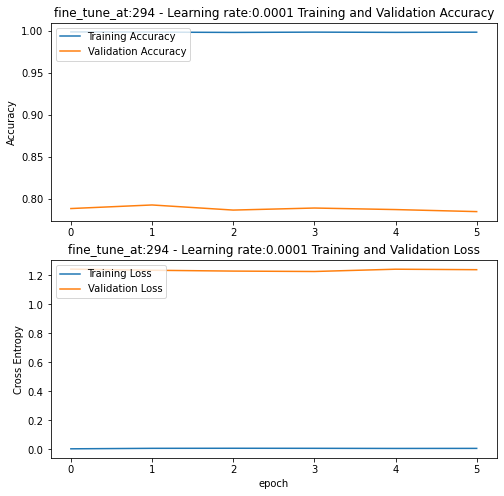


Learning rate: 1e-05
Epoch 1/20
464/464 [==============================] - 41s 82ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 1.2334 - val_accuracy: 0.7923
Epoch 2/20
464/464 [==============================] - 37s 80ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 1.2306 - val_accuracy: 0.7930
Epoch 3/20
464/464 [==============================] - 38s 83ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 1.2289 - val_accuracy: 0.7893
Epoch 4/20
464/464 [==============================] - 39s 83ms/step - loss: 0.0039 - accuracy: 0.9986 - val_loss: 1.2273 - val_accuracy: 0.7911
Epoch 5/20
464/464 [==============================] - 38s 82ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 1.2333 - val_accuracy: 0.7936
Epoch 6/20
464/464 [==============================] - 38s 82ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 1.2292 - val_accuracy: 0.7942
Epoch 7/20
464/464 [==============================] - 37s 80ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 

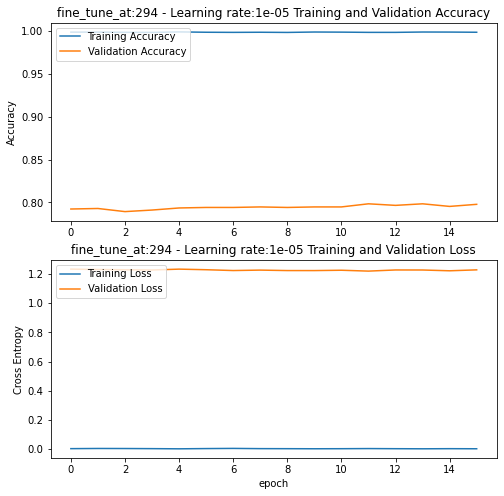


----------------------------------------------------------------------------------------------------
fine_tune_at: 299
Learning rate: 0.0001
Epoch 1/20
464/464 [==============================] - 41s 81ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 1.2262 - val_accuracy: 0.7923
Epoch 2/20
464/464 [==============================] - 37s 80ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 1.2251 - val_accuracy: 0.7887
Epoch 3/20
464/464 [==============================] - 39s 84ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 1.2556 - val_accuracy: 0.7948
Epoch 4/20
464/464 [==============================] - 38s 82ms/step - loss: 0.0071 - accuracy: 0.9987 - val_loss: 1.2509 - val_accuracy: 0.8009
Epoch 5/20
464/464 [==============================] - 41s 89ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 1.2434 - val_accuracy: 0.7966
Epoch 6/20
464/464 [==============================] - 41s 89ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 1.2489 - val_accuracy: 0

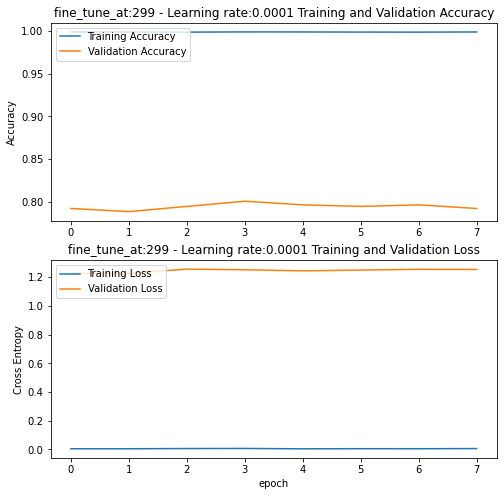


Learning rate: 1e-05
Epoch 1/20
464/464 [==============================] - 45s 85ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 1.2484 - val_accuracy: 0.7984
Epoch 2/20
464/464 [==============================] - 39s 84ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 1.2490 - val_accuracy: 0.7972
Epoch 3/20
464/464 [==============================] - 39s 84ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 1.2492 - val_accuracy: 0.7996
Epoch 4/20
464/464 [==============================] - 40s 87ms/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 1.2477 - val_accuracy: 0.7984
Epoch 5/20
464/464 [==============================] - 40s 87ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 1.2458 - val_accuracy: 0.7990
Epoch 6/20
464/464 [==============================] - 40s 87ms/step - loss: 0.0038 - accuracy: 0.9987 - val_loss: 1.2455 - val_accuracy: 0.7978
Epoch 7/20
464/464 [==============================] - 40s 87ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 

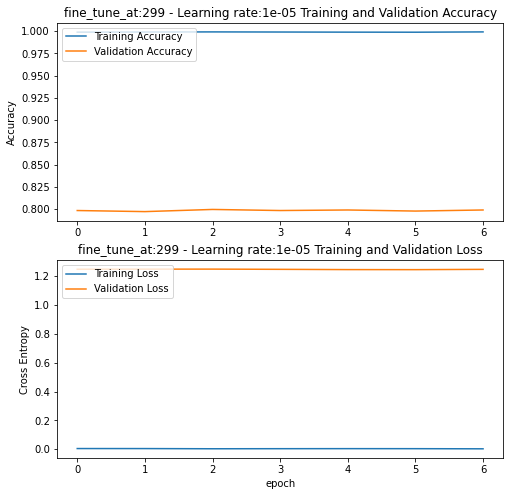

In [18]:
for fine_tune_at in [283, 289, 294, 299]:
    print('-'*100)
    print('fine_tune_at:', fine_tune_at)
    
    # Unfreeze model layers
    base_model.trainable = True
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # Test learning rates
    for lr in [1e-4, 1e-5]:
        print('Learning rate:', lr)
        # define new model
        model = Model(inputs=base_model.inputs, outputs=base_model.output)
        # Build Adam optimizer with selected learning rate
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        # Compile the model
        model.compile(loss='categorical_crossentropy',
                      optimizer=opt, metrics=['accuracy'])
        # Fit the model
        history = model.fit(train,
                            epochs=20,
                            validation_data=val,
                            callbacks=[get_early_stopping(4)])
        # Display history
        display_results('fine_tune_at:' + str(fine_tune_at) + ' - Learning rate:' + str(lr), history)   

        model = None
        print('')

### Implement the best strategy

In [23]:
# Reload data from session 5
fit_time, pred_time, loss, score = load_session(5)

In [24]:
# Generate train, validation and test sets
# No data augmentation and no equalization
train, val, test = preprocessing(True, pii, False, 32, False)

Found 14822 images belonging to 120 classes.
Found 1647 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.


In [25]:
# Load model
base_model = tf.keras.models.load_model('InceptionV3')

In [34]:
# Unfreeze model layers
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 299

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [31]:
# Fight against overfitting
base_model.layers[314].rate = 0.7
base_model.layers[317].rate = 0.7

In [35]:
# define new model
model = Model(inputs=base_model.inputs, outputs=base_model.output)

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [39]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [40]:
# Fit the model
start = datetime.now()
history_InceptionV3_tuned = model.fit(train,
                                      epochs=100,
                                      validation_data=val,
                                      callbacks=[get_early_stopping(10)])
end = datetime.now()
print('Fit time:', time_diff(start, end) / len(train.filepaths))
fit_time['InceptionV3_tuned'] = time_diff(start, end) / len(train.filepaths)

Epoch 1/100
464/464 [==============================] - 43s 79ms/step - loss: 0.4983 - accuracy: 0.8485 - val_loss: 0.8256 - val_accuracy: 0.8130
Epoch 2/100
464/464 [==============================] - 36s 78ms/step - loss: 0.4011 - accuracy: 0.8807 - val_loss: 0.8311 - val_accuracy: 0.8148
Epoch 3/100
464/464 [==============================] - 36s 78ms/step - loss: 0.3423 - accuracy: 0.8900 - val_loss: 0.8362 - val_accuracy: 0.8166
Epoch 4/100
464/464 [==============================] - 37s 79ms/step - loss: 0.3269 - accuracy: 0.8987 - val_loss: 0.8368 - val_accuracy: 0.8179
Epoch 5/100
464/464 [==============================] - 36s 78ms/step - loss: 0.2811 - accuracy: 0.9092 - val_loss: 0.8304 - val_accuracy: 0.8160
Epoch 6/100
464/464 [==============================] - 36s 78ms/step - loss: 0.2646 - accuracy: 0.9176 - val_loss: 0.8558 - val_accuracy: 0.8148
Epoch 7/100
464/464 [==============================] - 36s 78ms/step - loss: 0.2497 - accuracy: 0.9192 - val_loss: 0.8701 - val_ac

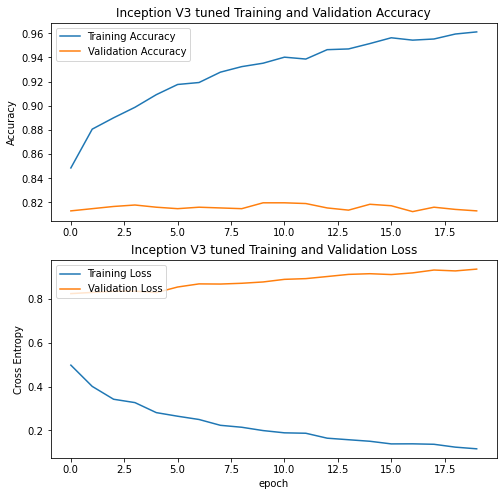

In [41]:
display_results('Inception V3 tuned', history_InceptionV3_tuned)

In [42]:
results_InceptionV3_tuned = model.evaluate(test)
print(f"test loss, test acc: {results_InceptionV3_tuned}")
loss['InceptionV3_tuned'] = results_InceptionV3_tuned[0]
score['InceptionV3_tuned'] = results_InceptionV3_tuned[1]

129/129 [==============================] - 10s 71ms/step - loss: 0.8685 - accuracy: 0.8171
test loss, test acc: [0.8685179948806763, 0.8170761466026306]


In [43]:
start = datetime.now()
predictions_InceptionV3_tuned = model.predict(test)
end = datetime.now()
print('Prediction time:', time_diff(start, end) / len(test.filepaths))
pred_time['InceptionV3_tuned'] = time_diff(start, end) / len(test.filepaths)

Prediction time: 0.002342278277791292


### Check point

In [44]:
dump_session(6)

In [45]:
model.save('InceptionV3_tuned')

INFO:tensorflow:Assets written to: InceptionV3_tuned\assets


## Final results

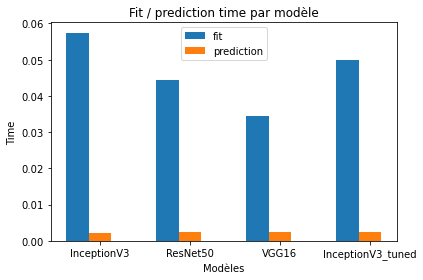

In [46]:
ind = np.arange(4) 
width = 0.25       
plt.bar(ind, fit_time.values(), width, label='fit')
plt.bar(ind + width, pred_time.values(), width, label='prediction')

plt.xlabel('Modèles')
plt.ylabel('Time')
plt.title('Fit / prediction time par modèle')

plt.xticks(ind + width, ['InceptionV3', 'ResNet50', 'VGG16', 'InceptionV3_tuned'])
plt.legend(loc='best')

plt.tight_layout()
plt.gcf().savefig('fit_approche2_final', dpi=100)
plt.show()

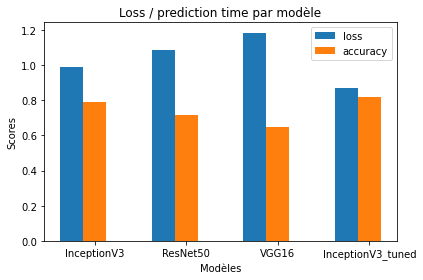

In [47]:
ind = np.arange(4) 
width = 0.25       
plt.bar(ind, loss.values(), width, label='loss')
plt.bar(ind + width, score.values(), width, label='accuracy')

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Loss / prediction time par modèle')

plt.xticks(ind + width, ['InceptionV3', 'ResNet50', 'VGG16', 'InceptionV3_tuned'])
plt.legend(loc='best')

plt.tight_layout()
plt.gcf().savefig('loss_approche2_final', dpi=100)
plt.show()